In [1]:
# import installed modules
# --------------------------------------------------------------
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
# import local modules from src
# --------------------------------------------------------------
from src.data.utils import *
from src.data.load_data import Data
from src.data.clean_data_tables import *
from src.matplotconf import matsettings
from src.models.brune_coeffs import BRUNE_COEFFS
from src.models.mw_corrections import compute_holt19_mo_and_mw

# 1. Data Prep and Exploration  
This notebook is for producing cleaning and producing the datasets required to train and test multi-linear regression models.

In [2]:
# load the raw data
PHASE = "S"
eq_cat = Data.load_file("raw", "catalogs", "UTeq.csv")
vm = load_vel_mod("../data/metadata/velocity_models/WUS.mod")
spec_pars_1 = Data.load_file("raw", "observations", f"ModelFitDb-{PHASE}g-1-2km.csv")
spec_pars_2 = Data.load_file("raw", "observations", f"ModelFitDb-{PHASE}g-2-2km.csv")
mags = Data.load_file("raw", "magnitudes", f"HOLT19-MwDirect-{PHASE}g-2km.csv")

### Get some informative outlier caps for the magnitude and observational data tables.

In [3]:
# some useful globals
MIN_NSTA = 3
MAX_STD_ERR = 0.25
MIN_DEP = 3
MAX_FC = spec_pars_1.data["fc"][
    spec_pars_1.data["fc"] < spec_pars_1.data["fc"].max() / 1E6
    ].describe()["max"]

### Clean the observations and magnitude data tables
Observations computed via method of Holt *et al*. (2021) and Mw computed via Holt (2019) (Chapter 2).

In [4]:
mag_table = clean_mag_table(mags.data, MIN_NSTA, MAX_STD_ERR) # target
fit_table = clean_fit_table(spec_pars_1.data, MIN_DEP, MAX_FC) # predictors
comb = pd.merge(fit_table, mag_table, on='otime') # combine the data tables 
comb = comb[['station', 'dep', 'repi', 'rhyp','llpsp', 'fc', 'Mw']]  # isolate important predictors and target data

### Compute M0 and Mw at each station using Holt (2019)  

In [8]:
final_comb = compute_holt19_mo_and_mw(comb, PHASE, BRUNE_COEFFS, vm)
final_comb.to_csv("../data/processed/comb-db-2-Sg-2km.csv", index=False)

### Look at the resultant data table

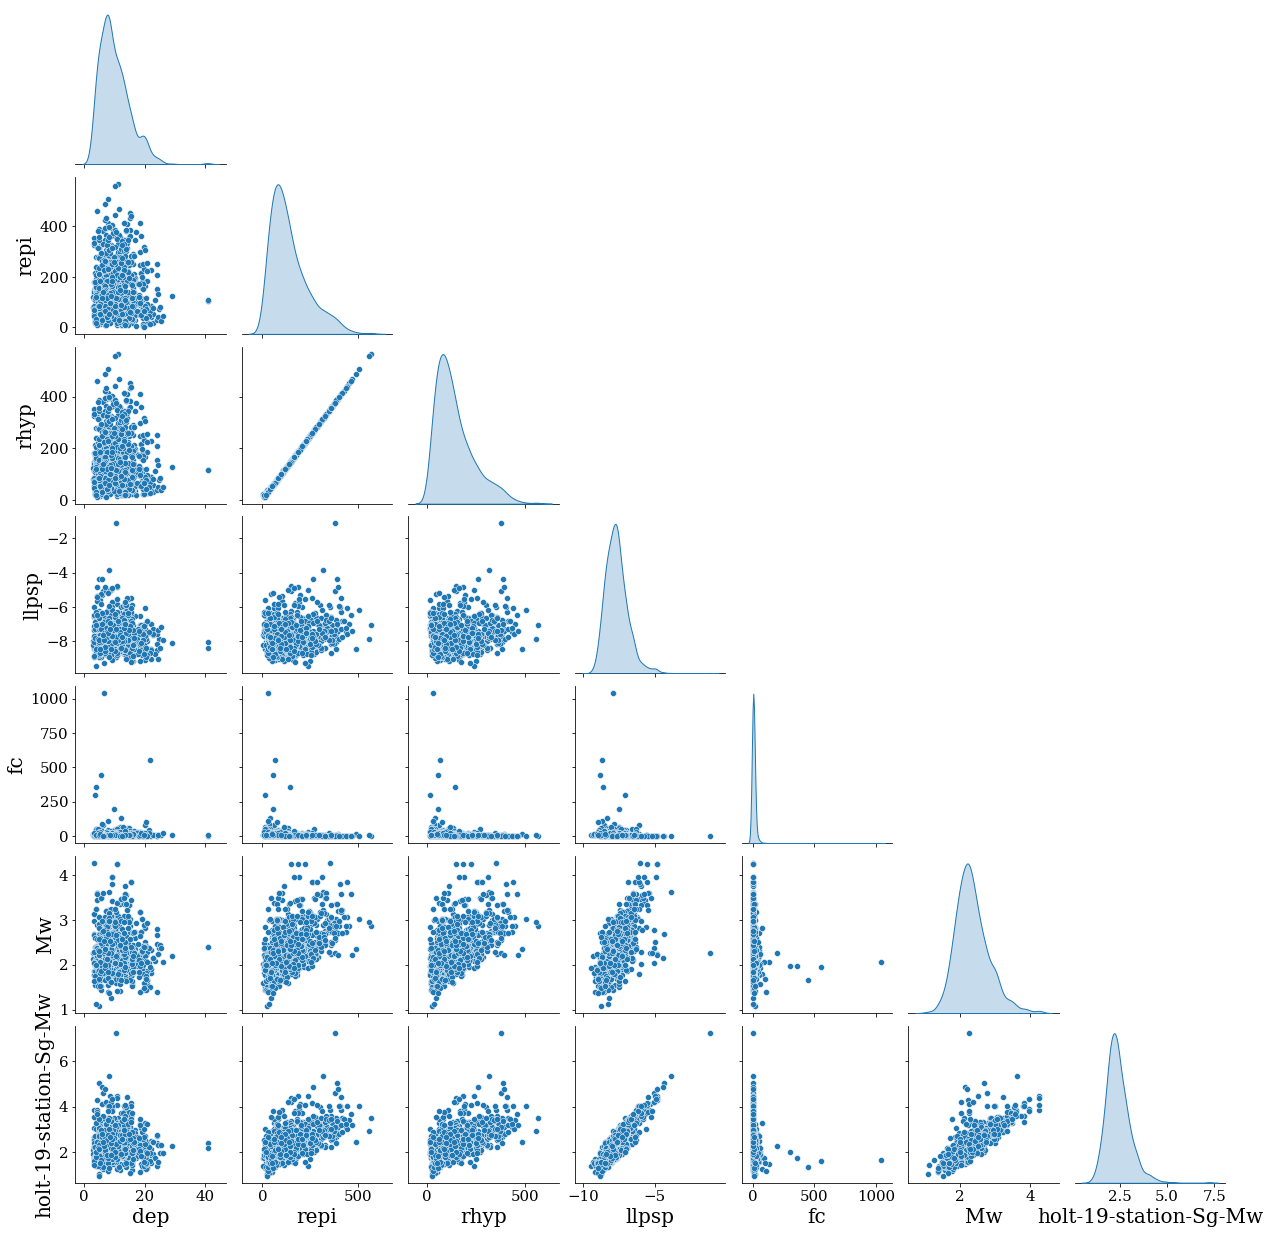

In [6]:
sns.pairplot(final_comb[['station', 'dep', 'repi', 'rhyp','llpsp', 'fc', 'Mw', f"holt-19-station-{PHASE}g-Mw"]].sample(1000), diag_kind='kde', corner=True)